# Conditional VAE

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

from torchvision import transforms
from torchvision.datasets import MNIST
from torch.optim import Adam
from torch.utils.data import DataLoader
from torch import Tensor
from tqdm import tqdm

# Set the main device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Load data

In [3]:
# CAR DATA
# Load car data for project 2
import torchvision
from torchvision import transforms
from PIL import Image
import torch
import numpy as np
import litdata


class ToRGBTensor:
    """Code from Mariuaas copied from Discourse"""
    def __call__(self, img):
        return transforms.functional.to_tensor(img).expand(3, -1, -1)  # Expand to 3 channels

    def __repr__(self) -> str:
        return f"{self.__class__.__name__}()"
    
    
class GetMoiraLabel:
    def __call__(self, tensor):
        return int(tensor.squeeze()[1])

    def __repr__(self) -> str:
        return f"{self.__class__.__name__}()"


def get_data(input_shape: list):
    """
    Get train and test data loader based on educload .tar data
    Code adapted from Mariuaas from Discourse
    """
    # Define data path
    DATA_PATH = '/projects/ec232/data/'

    # Define mean and std from ImageNet data
    IN_MEAN = [0.485, 0.456, 0.406]
    IN_STD = [0.229, 0.224, 0.225]

    # Define postprocessing / transform of data modalities
    postprocess = (  # Create tuple for image and class...
        transforms.Compose([  # Handles processing of the .jpg image
            ToRGBTensor(),  # Convert from PIL image to RGB torch.Tensor
            transforms.Grayscale(num_output_channels=input_shape[2]),
            transforms.Resize(input_shape[:2]),  # Resize images
            #transforms.Normalize(IN_MEAN, IN_STD),  # Normalize image to correct mean/std
            #transforms.Normalize(0.5, 0.5),
            
        ]),
        transforms.Compose([  # Handles processing of the .jpg image
            transforms.ToTensor(), # Convert .scores.npy file to tensor
            GetMoiraLabel(),
        ])
    )

    # Load data
    data = litdata.LITDataset(
        "CarRecs",
        DATA_PATH,
        override_extensions=["jpg", "scores.npy"],  # first load image, then scores
    ).map_tuple(*postprocess)

    return data

N_CHANNELS = 1
#INPUT_SHAPE = [96, 96, N_CHANNELS]
INPUT_SHAPE = [28, 28, N_CHANNELS]
# INPUT_SHAPE = [96, 128, N_CHANNELS]
batch_size = 64 * 4

ORIGINAL = False
train_set = get_data(INPUT_SHAPE)

# Create data loader
train_loader = DataLoader(train_set, shuffle=True, batch_size=batch_size)
train_set[0][0].size()

/projects/ec232/venvs/in5310/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


torch.Size([1, 28, 28])

In [4]:
ORIGINAL = True

In [5]:
train_set[0][0]

tensor([[[0.3651, 0.3071, 0.3184, 0.3981, 0.2040, 0.2399, 0.1149, 0.0793,
          0.0598, 0.3654, 0.0873, 0.1678, 0.2175, 0.1723, 0.1702, 0.2607,
          0.1740, 0.1987, 0.1874, 0.3287, 0.4106, 0.4207, 0.3178, 0.2477,
          0.2932, 0.3610, 0.3210, 0.4523],
         [0.5054, 0.3172, 0.0962, 0.5261, 0.2245, 0.2551, 0.2998, 0.1964,
          0.1210, 0.4555, 0.1492, 0.0876, 0.1160, 0.2000, 0.2342, 0.2266,
          0.2404, 0.2181, 0.2096, 0.2199, 0.3168, 0.3570, 0.2840, 0.2595,
          0.3302, 0.3206, 0.3387, 0.4719],
         [0.2687, 0.1913, 0.0896, 0.2180, 0.1852, 0.1343, 0.1326, 0.2753,
          0.1499, 0.4075, 0.1960, 0.0670, 0.1821, 0.1625, 0.1911, 0.2454,
          0.3370, 0.3321, 0.6601, 0.5612, 0.7381, 0.2864, 0.2713, 0.2132,
          0.3560, 0.3108, 0.3477, 0.5785],
         [0.1596, 0.1020, 0.0882, 0.1386, 0.0821, 0.1292, 0.3641, 0.1508,
          0.1683, 0.1964, 0.1600, 0.3470, 0.2151, 0.2673, 0.2825, 0.2765,
          0.2368, 0.1451, 0.1500, 0.6034, 0.5861, 0.1804,

In [6]:
r"""
# MNIST DATA
# Choose the path where you will/have already saved the MNIST dataset
data_dir = '/fp/projects01/ec232/data'

# Get dataset
ORIGINAL = True
batch_size = 64 * 4
INPUT_SHAPE = [28, 28, 1]
N_CHANNELS = 1
transform = transforms.ToTensor()
train_set = MNIST(root=data_dir, train=True, download=True, transform=transform)
N = len(train_set)

# Create data loader
train_loader = DataLoader(train_set, shuffle=True, batch_size=batch_size)
train_set[0][0].size()
"""

"\n# MNIST DATA\n# Choose the path where you will/have already saved the MNIST dataset\ndata_dir = '/fp/projects01/ec232/data'\n\n# Get dataset\nORIGINAL = True\nbatch_size = 64 * 4\nINPUT_SHAPE = [28, 28, 1]\nN_CHANNELS = 1\ntransform = transforms.ToTensor()\ntrain_set = MNIST(root=data_dir, train=True, download=True, transform=transform)\nN = len(train_set)\n\n# Create data loader\ntrain_loader = DataLoader(train_set, shuffle=True, batch_size=batch_size)\ntrain_set[0][0].size()\n"

## Helper functions

In [7]:
def reparameterize_gaussian(mean, std):
    """
    Inputs:
        mean : [torch.tensor] Mean vector. Shape: batch_size x z_dim.
        std  : [torch.tensor] Standard deviation vection. Shape: batch_size x z_dim.
    
    Output:
        z    : [torch.tensor] z sampled from the Normal distribution with mean and standard deviation given by the inputs. 
                              Shape: batch_size x z_dim.
    """

    # Sample epsilon from N(0,I)
    eps = torch.randn_like(std)

    # Calculate z using reparameterization trick
    z = mean + std*eps

    return z

In [8]:
def get_vae_loss(x, x_hat, mean, logvar):
    """
    Inputs:
        x       : [torch.tensor] Original sample
        x_hat   : [torch.tensor] Reproduced sample
        mean    : [torch.tensor] Mean mu of the variational posterior given sample x
        logvar  : [torch.tensor] log of the variance sigma^2 of the variational posterior given sample x
    """

    # Recontruction loss
    reconstruction_loss = ((x - x_hat)**2).sum()
    #print("RL", reconstruction_loss)
    
    # KL divergence
    KL_divergence = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
    #print("KL", KL_divergence)
    
    # Get the total loss
    kl_weight = 1
    loss = reconstruction_loss + KL_divergence * kl_weight

    return loss / 10

In [9]:
class ResidualLayer(nn.Module):
    def __init__(self,
                 in_channels: int,
                 out_channels: int):
        super(ResidualLayer, self).__init__()
        self.resblock = nn.Sequential(nn.Conv2d(in_channels, out_channels,
                                                kernel_size=3, padding=1, bias=False),
                                      nn.ReLU(True),
                                      nn.Conv2d(out_channels, out_channels,
                                                kernel_size=1, bias=False))

    def forward(self, input: Tensor) -> Tensor:
        return input + self.resblock(input)

# cVAE

In [10]:
class CEncoder(nn.Module):
    """ Convolutional encoder for the CVAE. """

    def __init__(self, z_dim, n_classes, n_channels):
        super().__init__()

        feature_dim = 32 * 23 * 31
        if ORIGINAL: feature_dim = 32 * 6 * 6  # TODO HOW DO I ARRIVE AT THESE NUMBERS?
        self.conv1 = nn.Conv2d(n_channels + 1, 64, kernel_size=3, stride=2)
        self.conv2 = nn.Conv2d(64, 32, kernel_size=3, stride=2)
        self.mean_fc = nn.Linear(feature_dim, z_dim)
        self.logvar_fc = nn.Linear(feature_dim, z_dim)
        self.cls_token_fc = nn.Linear(feature_dim, n_classes)

    def forward(self, x):
        #x = torch.flatten(x)
        #print("forward encoder:", x.size())
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        #print(x.size())  # [64, 32, 23, 31]  # [64, 32, 6, 6]
        x = x.flatten(1)
        
        # TODO also try out other priors
        mean = self.mean_fc(x)
        logvar = self.logvar_fc(x)
        cls_token = self.cls_token_fc(x)

        return mean, logvar, cls_token

In [11]:
class CDecoder(nn.Module):
    """ Convolutional decoder for the CVAE. """

    def __init__(self, z_dim, n_classes, n_channels):
        super().__init__()
        
        feature_dim = 32 * 23 * 31
        if ORIGINAL: feature_dim = 32 * 6 * 6
        self.fc = nn.Linear(z_dim + n_classes, feature_dim)
        self.conv2 = nn.ConvTranspose2d(32, 64, kernel_size=3, stride=2)
        self.conv1 = nn.ConvTranspose2d(64, n_channels, kernel_size=3, stride=2, output_padding=1)

    def forward(self, z):
        # print("dec z.size()", z.size())
        x = F.relu(self.fc(z))
        if ORIGINAL: x = x.view(-1, 32, 6, 6) 
        else: x = x.view(-1, 32, 23, 31)
        x = F.relu(self.conv2(x))
        x = self.conv1(x)
        x = torch.sigmoid(x)
        
        return x

## Extended cVAE

In [12]:
class CEncoder(nn.Module):
    """ Convolutional encoder for the CVAE. """

    def __init__(self, z_dim, n_classes, n_channels, hidden_dims=None):
        super().__init__()

        in_channels = n_channels + 1
                
        if hidden_dims is None:
            hidden_dims = [32, 64, 128, 256, 512]
            #hidden_dims = [32, 128, 512]

        modules = []
        for h_dim in hidden_dims:
            modules.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, out_channels=h_dim,
                              kernel_size=3, stride=2, padding=1),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU())
            )
            in_channels = h_dim
        
        self.encoder = nn.Sequential(*modules)
        
        feature_dim = 512 * 3 * 3
        if ORIGINAL: feature_dim = 512 * 1 * 1
        self.mean_fc = nn.Linear(feature_dim, z_dim)
        self.logvar_fc = nn.Linear(feature_dim, z_dim)
        self.cls_token_fc = nn.Linear(feature_dim, n_classes)

    def forward(self, x):
        x = self.encoder(x)
        #print("!!! feature_dim:", x.size())  # [64, 32, 23, 31]  # [64, 32, 6, 6]
        x = x.flatten(1)
        
        # TODO also try out other priors
        mean = self.mean_fc(x)
        logvar = self.logvar_fc(x)
        cls_token = self.cls_token_fc(x)

        return mean, logvar, cls_token

In [13]:
class CDecoder(nn.Module):
    """ Convolutional decoder for the CVAE. """

    def __init__(self, z_dim, n_classes, n_channels, hidden_dims=None):
        super().__init__()
        
        feature_dim = 512 * 3 * 3
        if ORIGINAL: feature_dim = 512 * 1 * 1
        self.fc = nn.Linear(z_dim + n_classes, feature_dim)
        
        if hidden_dims is None:
            hidden_dims = [32, 64, 128, 256, 512]
            #hidden_dims = [32, 128, 512]
        hidden_dims.reverse()
        
        padding_last_layer = 1
        if ORIGINAL: padding_last_layer = 3
        modules = []
        for i in range(len(hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(hidden_dims[i],
                                       hidden_dims[i + 1],
                                       kernel_size=3,
                                       stride=2,
                                       padding=1,
                                       output_padding=1),
                    nn.BatchNorm2d(hidden_dims[i + 1]),
                    nn.LeakyReLU())
            )
        self.decoder = nn.Sequential(*modules)       
        
        self.final_layer = nn.Sequential(
                    nn.ConvTranspose2d(hidden_dims[-1],
                                       hidden_dims[-1],
                                       kernel_size=3,
                                       stride=2,
                                       padding=1,
                                       output_padding=1),
                    nn.BatchNorm2d(hidden_dims[-1]),
                    nn.LeakyReLU(),
                    nn.ConvTranspose2d(hidden_dims[-1], 
                              out_channels=n_channels,
                              kernel_size=3, 
                              padding=padding_last_layer),
                    nn.Tanh())

    def forward(self, z):
        x = self.fc(z)
        if ORIGINAL:  x = x.view(-1, 512, 1, 1)
        else: x = x.view(-1, 512, 3, 3)
        x = self.decoder(x)
        # print("after decoder:", x.size())
        x = self.final_layer(x)
        # print("after final_layer:", x.size())
        
        return x

## Declare cVAE

In [14]:
class CVAE(nn.Module):
    """ Conditional Variational Auto-Encoder class. """

    def __init__(self, z_dim, n_classes, n_channels=1, img_size=[28,28]):
        super().__init__()
        self.z_dim = z_dim
        self.n_classes = n_classes
        self.n_channels = n_channels
        self.img_size = img_size

        self.encoder = CEncoder(z_dim, n_classes, n_channels)
        self.decoder = CDecoder(z_dim, n_classes, n_channels)

        # Add learnable class token
        self.cls_param = nn.Parameter(torch.zeros(n_classes, *img_size))

    def get_cls_emb(self, c):
        return self.cls_param[c].unsqueeze(1)

    def forward(self, x, c):
        """
        Args:
            x   : [torch.Tensor] Image input of shape [batch_size, n_channels, *img_size]
            c   : [torch.Tensor] Class labels for x of shape [batch_size], where the class in indicated by a
        """

        # Get cls embedding
        cls_emb = self.get_cls_emb(c)

        # Concatenate cls embedding to the input
        #print("x.size() =", x.size())
        #print("cls_emb.size() =", cls_emb.size())
        x = torch.cat((x, cls_emb), dim=1)

        # Get the mean, logvar, and cls token from the encoder
        mean, logvar, cls_token = self.encoder(x)

        # Calculate the standard deviation. Note: in log-space, squareroot is divide by two
        std = torch.exp(logvar / 2)

        # Sample the latent using the reparameterization trick
        z = reparameterize_gaussian(mean, std)
        # print("######")
        # print("z.size() =", z.size())
        
        # Concatenate cls token to z
        z = torch.cat((z, F.softmax(cls_token, dim=1)), dim=1)
        
        # Get reconstructed x from the decoder
        x_hat = self.decoder(z)
        
        return x, x_hat, mean, logvar, cls_token

## Train model

In [15]:
# Initialize the VAE
z_dim = 128
conditioned_model = CVAE(z_dim, n_classes=10, n_channels=N_CHANNELS, img_size=INPUT_SHAPE[:2]).to(device)

# Feel free to tweak the training parameters
epochs = 25
lr = 0.00001
optimizer = Adam(conditioned_model.parameters(), lr=lr)

# Train for a few epochs
conditioned_model.train()

losses = []

# TODO USE: with traindata.shufflecontext(): 2 # do training loop ...
for epoch in range(epochs):
    train_bar = tqdm(iterable=train_loader)
    total_loss = 0
    for i, (x, c) in enumerate(train_bar):
        x = x.to(device)
        c = c.to(device)
        # Get x_hat, mean, logvar,and cls_token from the conditioned_model
        x, x_hat, mean, logvar, cls_token = conditioned_model.forward(x, c)
        x = x[:, :N_CHANNELS, :, :] # excluding cls_emebdding

        # Get vae loss
        #print("x.size() =", x.size())
        #print("x_hat.size() =", x_hat.size())        
        vae_loss = get_vae_loss(x, x_hat, mean, logvar)

        # Get cross entropy loss for the cls token
        # print("cls_token.size() =", cls_token.size())
        # print("OHE", F.one_hot(c, num_classes=10).double().size())
        cls_loss = F.cross_entropy(cls_token, F.one_hot(c, num_classes=10).double(), reduction='sum')

        # Add the losses as a weighted sum. NB: We weight the cls_loss by 10 here, but feel free to tweak it.
        loss = vae_loss + cls_loss  #* 10 # reducing vae_loss instead
        total_loss += loss / len(x)
        
        # Update model parameters based on loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_bar.set_description(f'Epoch [{epoch+1}/{epochs}]')
        train_bar.set_postfix(loss = loss.item() / len(x))
    losses.append(total_loss.item())
    print("Total loss:", losses[-1])

Epoch [1/25]: 100%|██████████| 24/24 [00:30<00:00,  1.28s/it, loss=47]  


Total loss: 1222.9691718969095


Epoch [2/25]: 100%|██████████| 24/24 [00:28<00:00,  1.18s/it, loss=42.4]


Total loss: 1072.555681640382


Epoch [3/25]: 100%|██████████| 24/24 [00:28<00:00,  1.18s/it, loss=36.1]


Total loss: 938.4434882530477


Epoch [4/25]: 100%|██████████| 24/24 [00:27<00:00,  1.17s/it, loss=31.4]


Total loss: 813.2457742348446


Epoch [5/25]: 100%|██████████| 24/24 [00:29<00:00,  1.22s/it, loss=26.6]


Total loss: 693.0646948994836


Epoch [6/25]: 100%|██████████| 24/24 [00:29<00:00,  1.24s/it, loss=22]  


Total loss: 580.869300053904


Epoch [7/25]: 100%|██████████| 24/24 [00:29<00:00,  1.22s/it, loss=19]  


Total loss: 484.04609878694674


Epoch [8/25]: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it, loss=16]  


Total loss: 413.4567038637054


Epoch [9/25]: 100%|██████████| 24/24 [00:29<00:00,  1.25s/it, loss=14]  


Total loss: 365.32087103787177


Epoch [10/25]: 100%|██████████| 24/24 [00:30<00:00,  1.27s/it, loss=13.1]


Total loss: 332.4026621742606


Epoch [11/25]: 100%|██████████| 24/24 [00:28<00:00,  1.21s/it, loss=12.4]


Total loss: 307.70969168403616


Epoch [12/25]: 100%|██████████| 24/24 [00:29<00:00,  1.22s/it, loss=11.6]


Total loss: 289.4662256795896


Epoch [13/25]: 100%|██████████| 24/24 [00:28<00:00,  1.18s/it, loss=11.3]


Total loss: 274.9684812203715


Epoch [14/25]: 100%|██████████| 24/24 [00:29<00:00,  1.22s/it, loss=10.6]


Total loss: 263.0594315975489


Epoch [15/25]: 100%|██████████| 24/24 [00:28<00:00,  1.19s/it, loss=10.6]


Total loss: 252.6300822784542


Epoch [16/25]: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it, loss=10.8]


Total loss: 245.40508824691642


Epoch [17/25]: 100%|██████████| 24/24 [00:40<00:00,  1.69s/it, loss=9.7] 


Total loss: 237.18552539377873


Epoch [18/25]: 100%|██████████| 24/24 [00:42<00:00,  1.77s/it, loss=9.27]


Total loss: 230.4366478736213


Epoch [19/25]: 100%|██████████| 24/24 [00:32<00:00,  1.34s/it, loss=9.21]


Total loss: 225.44998035836034


Epoch [20/25]: 100%|██████████| 24/24 [00:29<00:00,  1.24s/it, loss=9.12]


Total loss: 220.42621355216085


Epoch [21/25]: 100%|██████████| 24/24 [00:29<00:00,  1.22s/it, loss=9.05]


Total loss: 215.94090359307094


Epoch [22/25]: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it, loss=8.81]


Total loss: 211.90746022030777


Epoch [23/25]: 100%|██████████| 24/24 [00:30<00:00,  1.25s/it, loss=8.38]


Total loss: 208.00913135047136


Epoch [24/25]: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it, loss=8.57]


Total loss: 205.00064350243858


Epoch [25/25]: 100%|██████████| 24/24 [00:28<00:00,  1.20s/it, loss=8.24]

Total loss: 201.80623518564138


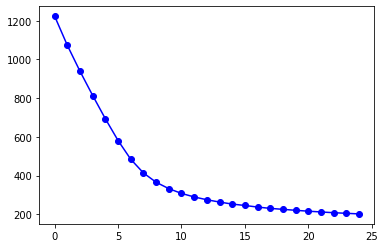

In [16]:
# Print convergence plot
plt.plot(losses, "-bo")

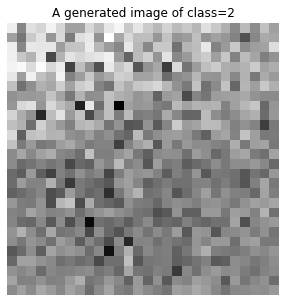

In [26]:
# Put model in evalulation mode
conditioned_model.eval()

# Select a class label
cls_label = 2

with torch.no_grad():
    # Sample noise from N(0,I)
    # TODO also try out other priors
    z = torch.randn(1, z_dim).to(device)

    # Make a one-hot for the selected class label, which will act as the cls token
    cls_token = F.one_hot(torch.tensor(cls_label).unsqueeze(0), num_classes=10).to(device)

    # Concatenate z and the cls token
    z = torch.cat((z, cls_token), dim=1)  # TODO prob this should be saved acc to instructions!

    # Generate new image with the decoder
    x_hat = conditioned_model.decoder(z)
    x_hat = x_hat.squeeze(0).cpu().detach()

# Show generated image
plt.figure(figsize=(5,5))
x_hat_permuted = x_hat.permute(1, 2 ,0)
#plt.imshow((x_hat_permuted+1)*.5, cmap=plt.get_cmap('gray'))
plt.imshow(x_hat_permuted, cmap=plt.get_cmap('gray'))
plt.title(f"A generated image of class={cls_label}")
plt.axis('off')
plt.show()

In [27]:
for epoch in range(epochs):
    train_bar = tqdm(iterable=train_loader)
    total_loss = 0
    for i, (x, c) in enumerate(train_bar):
        x = x.to(device)
        c = c.to(device)
        # Get x_hat, mean, logvar,and cls_token from the conditioned_model
        x, x_hat, mean, logvar, cls_token = conditioned_model.forward(x, c)
        x = x[:, :N_CHANNELS, :, :] # excluding cls_emebdding

        # Get vae loss
        #print("x.size() =", x.size())
        #print("x_hat.size() =", x_hat.size())        
        vae_loss = get_vae_loss(x, x_hat, mean, logvar)

        # Get cross entropy loss for the cls token
        # print("cls_token.size() =", cls_token.size())
        # print("OHE", F.one_hot(c, num_classes=10).double().size())
        cls_loss = F.cross_entropy(cls_token, F.one_hot(c, num_classes=10).double(), reduction='sum')

        # Add the losses as a weighted sum. NB: We weight the cls_loss by 10 here, but feel free to tweak it.
        loss = vae_loss + cls_loss  #* 10 # reducing vae_loss instead
        total_loss += loss / len(x)
        
        # Update model parameters based on loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_bar.set_description(f'Epoch [{epoch+1}/{epochs}]')
        train_bar.set_postfix(loss = loss.item() / len(x))
    losses.append(total_loss.item())
    print("Total loss:", losses[-1])

Epoch [1/25]: 100%|██████████| 24/24 [00:30<00:00,  1.26s/it, loss=7.56]


Total loss: 192.46822849247005


Epoch [2/25]: 100%|██████████| 24/24 [00:29<00:00,  1.22s/it, loss=7.47]


Total loss: 185.56736832457995


Epoch [3/25]: 100%|██████████| 24/24 [00:29<00:00,  1.22s/it, loss=7.56]


Total loss: 183.09136972908996


Epoch [4/25]: 100%|██████████| 24/24 [00:29<00:00,  1.25s/it, loss=7.44]


Total loss: 181.0191375224053


Epoch [5/25]: 100%|██████████| 24/24 [00:29<00:00,  1.23s/it, loss=7.61]


Total loss: 179.7202076530084


Epoch [6/25]: 100%|██████████| 24/24 [00:29<00:00,  1.25s/it, loss=7.52]


Total loss: 178.04122784632324


Epoch [7/25]: 100%|██████████| 24/24 [00:31<00:00,  1.29s/it, loss=7.28]


Total loss: 176.92295691008414


Epoch [8/25]: 100%|██████████| 24/24 [00:29<00:00,  1.23s/it, loss=7.38]


Total loss: 175.912993389714


Epoch [9/25]: 100%|██████████| 24/24 [00:29<00:00,  1.24s/it, loss=7.26]


Total loss: 174.9484075319654


Epoch [10/25]: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it, loss=7.27]


Total loss: 173.66905414213292


Epoch [11/25]: 100%|██████████| 24/24 [00:29<00:00,  1.22s/it, loss=7.23]


Total loss: 172.90099945950456


Epoch [12/25]: 100%|██████████| 24/24 [00:29<00:00,  1.24s/it, loss=7.08]


Total loss: 172.05062670367104


Epoch [13/25]: 100%|██████████| 24/24 [00:30<00:00,  1.29s/it, loss=7.28]


Total loss: 171.49617884106868


Epoch [14/25]: 100%|██████████| 24/24 [00:29<00:00,  1.22s/it, loss=7.19]


Total loss: 170.46800978729567


Epoch [15/25]: 100%|██████████| 24/24 [00:30<00:00,  1.27s/it, loss=7.01]


Total loss: 169.93628848114582


Epoch [16/25]: 100%|██████████| 24/24 [00:29<00:00,  1.24s/it, loss=7.12]


Total loss: 169.24930181873165


Epoch [17/25]: 100%|██████████| 24/24 [00:29<00:00,  1.24s/it, loss=6.88]


Total loss: 168.38182117038272


Epoch [18/25]: 100%|██████████| 24/24 [00:30<00:00,  1.26s/it, loss=6.55]


Total loss: 167.49054485928667


Epoch [19/25]: 100%|██████████| 24/24 [00:29<00:00,  1.22s/it, loss=6.86]


Total loss: 167.1767656081356


Epoch [20/25]: 100%|██████████| 24/24 [00:29<00:00,  1.22s/it, loss=7.01]


Total loss: 166.42218654947024


Epoch [21/25]: 100%|██████████| 24/24 [00:30<00:00,  1.25s/it, loss=7.03]


Total loss: 165.91543338417873


Epoch [22/25]: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it, loss=6.84]


Total loss: 165.28124077619785


Epoch [23/25]: 100%|██████████| 24/24 [00:28<00:00,  1.21s/it, loss=6.89]


Total loss: 164.84071435365226


Epoch [24/25]: 100%|██████████| 24/24 [00:29<00:00,  1.22s/it, loss=6.98]


Total loss: 164.1474874230667


Epoch [25/25]: 100%|██████████| 24/24 [00:28<00:00,  1.21s/it, loss=7.06]

Total loss: 163.65281386437294


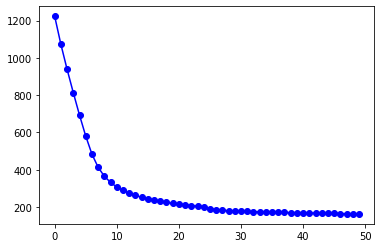

In [28]:
# Print convergence plot
plt.plot(losses, "-bo")

In [29]:
# This doesn't work
# x.size() = torch.Size([64, 4, 96, 128])
# x_hat.size() = torch.Size([64, 3, 96, 128])
#x - x_hat

To generate new images conditioned on a class label, we sample some noise $z \sim N(0,I)$ and concatenate the one-hot vector of the class label we want to condition on. Then we use the decoder to generate a new image.
If your CVAE model was trained correctly, the cell below should generate new images of the selected class.

## Get generations

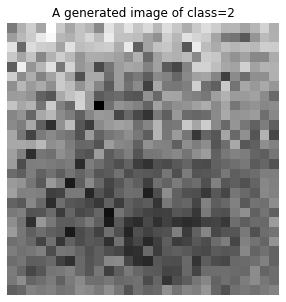

In [33]:
# Put model in evalulation mode
conditioned_model.eval()

# Select a class label
cls_label = 2

with torch.no_grad():
    # Sample noise from N(0,I)
    # TODO also try out other priors
    z = torch.randn(1, z_dim).to(device)

    # Make a one-hot for the selected class label, which will act as the cls token
    cls_token = F.one_hot(torch.tensor(cls_label).unsqueeze(0), num_classes=10).to(device)

    # Concatenate z and the cls token
    z = torch.cat((z, cls_token), dim=1)  # TODO prob this should be saved acc to instructions!

    # Generate new image with the decoder
    x_hat = conditioned_model.decoder(z)
    x_hat = x_hat.squeeze(0).cpu().detach()

# Show generated image
plt.figure(figsize=(5,5))
x_hat_permuted = x_hat.permute(1, 2 ,0)
#plt.imshow((x_hat_permuted+1)*.5, cmap=plt.get_cmap('gray'))
plt.imshow(x_hat_permuted, cmap=plt.get_cmap('gray'))
plt.title(f"A generated image of class={cls_label}")
plt.axis('off')
plt.show()

Preference score: 1


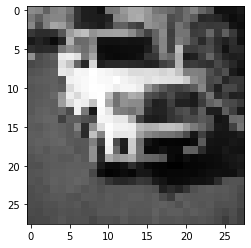

In [24]:
print("Preference score:", train_set[i][1])
plt.imshow(train_set[i][0].permute(1,2,0), cmap=plt.get_cmap('gray'))
plt.show()
i += 1

In [ ]:
for epoch in range(epochs):
    train_bar = tqdm(iterable=train_loader)
    total_loss = 0
    for i, (x, c) in enumerate(train_bar):
        x = x.to(device)
        c = c.to(device)
        # Get x_hat, mean, logvar,and cls_token from the conditioned_model
        x, x_hat, mean, logvar, cls_token = conditioned_model.forward(x, c)
        x = x[:, :N_CHANNELS, :, :] # excluding cls_emebdding

        # Get vae loss
        #print("x.size() =", x.size())
        #print("x_hat.size() =", x_hat.size())        
        vae_loss = get_vae_loss(x, x_hat, mean, logvar)

        # Get cross entropy loss for the cls token
        # print("cls_token.size() =", cls_token.size())
        # print("OHE", F.one_hot(c, num_classes=10).double().size())
        cls_loss = F.cross_entropy(cls_token, F.one_hot(c, num_classes=10).double(), reduction='sum')

        # Add the losses as a weighted sum. NB: We weight the cls_loss by 10 here, but feel free to tweak it.
        loss = vae_loss + cls_loss  #* 10 # reducing vae_loss instead
        total_loss += loss / len(x)
        
        # Update model parameters based on loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_bar.set_description(f'Epoch [{epoch+1}/{epochs}]')
        train_bar.set_postfix(loss = loss.item() / len(x))
    losses.append(total_loss.item())
    print("Total loss:", losses[-1])

Epoch [1/25]: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it, loss=6.95]


Total loss: 162.90423343769675


Epoch [2/25]: 100%|██████████| 24/24 [00:28<00:00,  1.19s/it, loss=6.56]


Total loss: 162.05517538312623


Epoch [3/25]: 100%|██████████| 24/24 [00:29<00:00,  1.22s/it, loss=6.72]


Total loss: 161.4320316199945


Epoch [4/25]: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it, loss=6.61]


Total loss: 160.61530260572076


Epoch [5/25]: 100%|██████████| 24/24 [00:29<00:00,  1.23s/it, loss=6.75]


Total loss: 160.49818857168844


Epoch [6/25]: 100%|██████████| 24/24 [00:27<00:00,  1.16s/it, loss=6.48]


Total loss: 159.21597929302203


Epoch [7/25]: 100%|██████████| 24/24 [00:29<00:00,  1.23s/it, loss=6.53]


Total loss: 158.49298781063408


Epoch [8/25]: 100%|██████████| 24/24 [00:29<00:00,  1.23s/it, loss=6.67]


Total loss: 157.9914374976818


Epoch [9/25]: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it, loss=6.54]


Total loss: 157.07247172091488


Epoch [10/25]: 100%|██████████| 24/24 [00:29<00:00,  1.22s/it, loss=6.53]


Total loss: 156.39774194547707


Epoch [11/25]: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it, loss=6.46]


Total loss: 155.34073091477953


Epoch [12/25]: 100%|██████████| 24/24 [00:29<00:00,  1.24s/it, loss=6.38]


Total loss: 154.3880054475823


Epoch [13/25]: 100%|██████████| 24/24 [00:28<00:00,  1.21s/it, loss=6.41]


Total loss: 153.30838108634012


Epoch [14/25]: 100%|██████████| 24/24 [00:29<00:00,  1.23s/it, loss=6.21]


Total loss: 151.93667271727463


Epoch [15/25]: 100%|██████████| 24/24 [00:29<00:00,  1.21s/it, loss=6.55]


Total loss: 151.02098990620496


Epoch [16/25]: 100%|██████████| 24/24 [00:29<00:00,  1.23s/it, loss=6]   


Total loss: 149.17499533520564


Epoch [17/25]: 100%|██████████| 24/24 [00:29<00:00,  1.22s/it, loss=6.4] 


Total loss: 148.06150480099936


Epoch [18/25]: 100%|██████████| 24/24 [00:29<00:00,  1.24s/it, loss=6.12]


Total loss: 146.48587377006646


Epoch [19/25]: 100%|██████████| 24/24 [00:30<00:00,  1.27s/it, loss=5.59]


Total loss: 144.69974981340056


Epoch [20/25]: 100%|██████████| 24/24 [00:28<00:00,  1.20s/it, loss=5.88]


Total loss: 143.18677429563


Epoch [21/25]: 100%|██████████| 24/24 [00:29<00:00,  1.24s/it, loss=5.48]


Total loss: 141.49274543869979


Epoch [22/25]: 100%|██████████| 24/24 [00:28<00:00,  1.19s/it, loss=6.07]


Total loss: 140.35394918289134


Epoch [23/25]: 100%|██████████| 24/24 [00:28<00:00,  1.21s/it, loss=5.59]


Total loss: 138.4656057018879


Epoch [24/25]:  92%|█████████▏| 22/24 [00:40<00:04,  2.30s/it, loss=5.65]

In [ ]:
# Print convergence plot
plt.plot(losses, "-bo")

### Dataset Analysis

In [20]:
raise Exception("stop")

Exception: stop

In [ ]:
scores = []
for i in range(len(train_set)):
    scores.append(train_set[i][1])

In [ ]:
from collections import Counter
Counter(scores)

In [ ]:
# Score = 9: [562, 2984, 3392, 4864]

In [ ]:
i = 4

In [ ]:
print("Preference score:", train_set[i][1])
permuted_train_set = train_set[i][0].permute(1,2,0)

plt.imshow((permuted_train_set+1)*.5, cmap=plt.get_cmap('gray'))
plt.show()
#i += 1

In [ ]:
(train_set[0][0]+1)*256/2